In [158]:
%pylab inline
import scipy.stats as stats
from scipy.stats import binom
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML, Image

Populating the interactive namespace from numpy and matplotlib


In our last example, we saw that we can use permutations of possible elections to quantify our confidence in an election outcome based on a sample drawn from an audit. However, we also saw that examining permutations isn't really feasible for real election results, since the number of comptuations necessary grows exponentially. 

Here we set out to address those challenges. If we can find a reasonable approximation of our permutation distribution, then maybe we can get somewhere. Let's start by recalling what we saw last time:

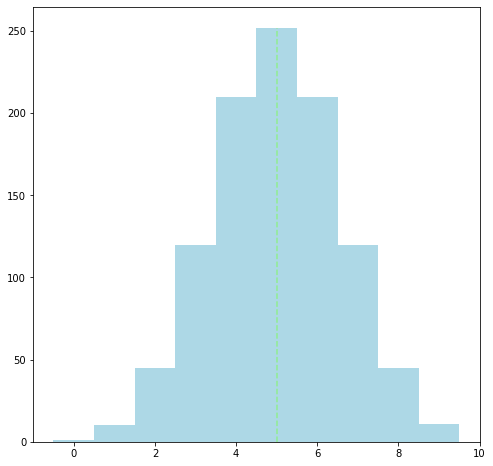

In [159]:
n = 10
margins = np.zeros(2**n)
for i in range(2**n):
    margins[i] = (np.sum([int(j) for j in list('{0:0b}'.format(i))]))

fig, ax = plt.subplots(figsize=(8,8))
counts, bins, _ = ax.hist(margins, color='lightblue', align='left')
ax.vlines(5, color='lightgreen', linestyle='dashed', ymin=0, ymax=max(counts))

Recall that we saw the total distribution of possible elections in the histogram above. With no knowledge about a specific election outcome, the distribution is distributed evenly around the midpoint outcome: a tie. We also saw that we can redraw this distribution so that rather than showing us a histogram, we get a summary of the probabilities of the various election outcomes. To use the parlance of probability, this new diagram shows a probability mass function (PMF), which can be seen below.

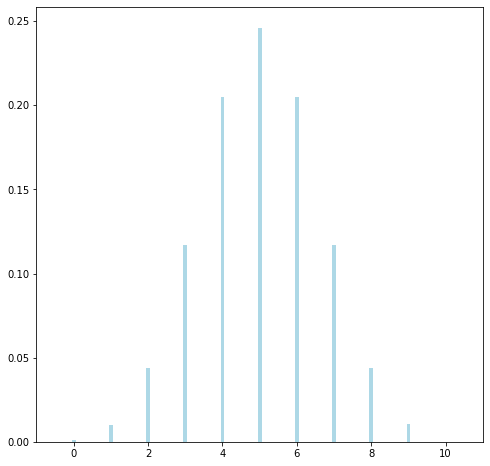

In [149]:
ax.cla()
counts, bins, _ = ax.hist(margins, bins=np.arange(0, 11), color='lightblue', density=True, rwidth=.1, align='left')
ax.set_xlim(-1, 11)
fig

Because it's impossible to have a fractional outcome, we show the various points without any filled in space between. The eagle-eyed among you may have by this point noted that that kind of looks a little bit like a normal distribution. Indeed, it does!

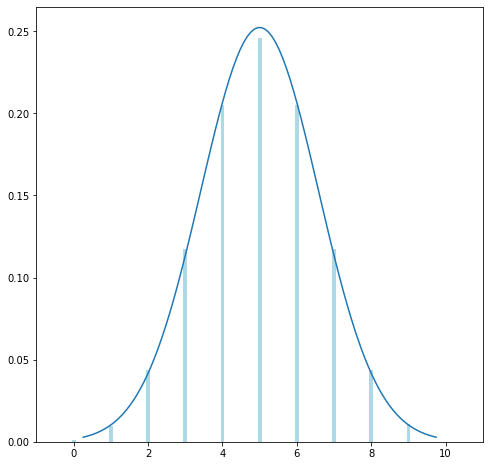

In [150]:
ax.cla()
mu = .5*n
variance = n*.5*(1 - .5)
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.hist(margins, bins=np.arange(0, 11), color='lightblue', density=True, rwidth=.1, align='left')
ax.set_xlim(-1, 11)
fig

Look at that! It's almost a perfect fit! Why is that?

This is a result of the Central Limit Theorem, which says that as n (in this case, the number of ballots) goes to infinity, the distribution of outcomes approaches a normal distribution. But how does this help us?

Going to our example from yesterday, a contest between Alice and Bob with no invalid votes, we saw how as we sampled more ballots, the distribution shifted toward the "true" underlying margin. Think about what we're doing here: we're conducting _trials_ with outcomes of 1 or 0, in series. Each of these trials is independent of each other. Wait a minute, that means they're Bernoulli trials! And when we do a bunch of them together, we get a binomial distribution! 

Thanks to a special case of the CLT, the De Moivre-Laplace theorem, we can use our binomial distribution to build a normal. You may have noticed the specific values I put in above to generate the normal. Those come straight from the De Moivre-Laplace theorem. Looking at the distribution we examined yesterday, if the true margin is 8 to 2, after 4 trials our distribution looks like this:

Variance: 2.40


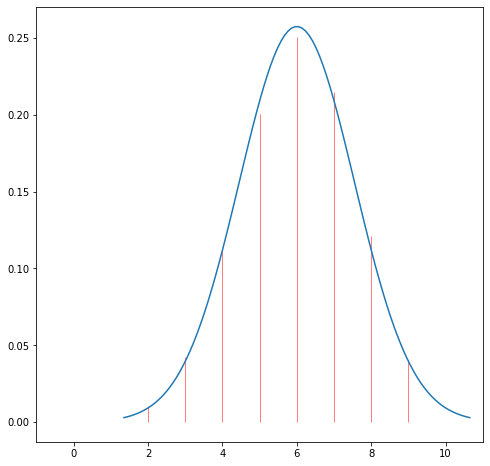

In [151]:
n = 10
votes = [0, 1, 1, 0, 0, 1,1,1,1,0]
m = 0
p = .6 # the margin

ax.cla()
x = np.arange(binom.ppf(0.01, n, p),
              binom.ppf(0.9999, n, p))

ax.vlines(x, 0, binom.pmf(x, n, p), colors='red', lw=1, alpha=0.5, )

mu = np.sum(votes)

variance = mu*(1 - mu/n)
print('Variance: {:2.2f}'.format(variance))


sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.set_xlim(-1, 11)
fig

Hmm, that doesn't quite look right. Why is that? It could be because our n is very small here, certainly compared to infinity! It could also be that because the normal distrubtion is continuous, it has a lot more places to "pack" probabilities, meaning it doesn't need to grow as high to add up to 1. 

To examine this, let's imagine that we take many more trials in a much larger election. Below we show how close the normalized histogram for an election with 1000 ballots is to the normal distribution. Because generating all $2^{1000}$ possible elections is computationally infeasible, I've opted to cheat a little bit and use Scipy's binomial pmf function. Hopefully by now I've coninced you that the two are functionally equivalent! 

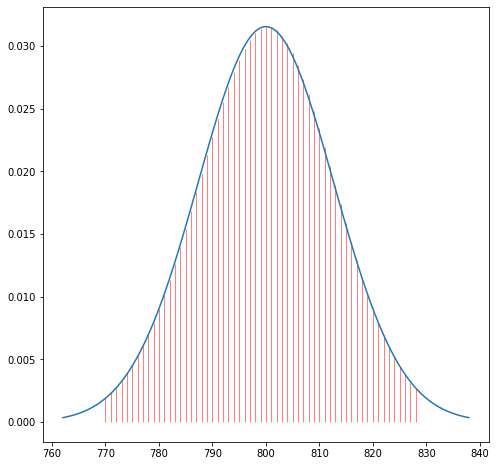

In [160]:
ax.cla()
p = .8
n = 1000
mu = p*n
variance = p*n*(1 - p)
sigma = math.sqrt(variance)
x = np.linspace((mu - 3*sigma), (mu + 3*sigma), 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
x = np.arange(binom.ppf(0.01, n, p),
              binom.ppf(0.99, n, p))


ax.vlines(x, 0, binom.pmf(x, n, p), colors='red', lw=1, alpha=0.5, )


fig

From here on out, we'll be using normal distributions to stand in for our binomial/histograms that we've used so far to represent the space of possible election outcomes. This embeds some assumptions, and offers a good opportunity to revisit many of the assumptions we've made so far. 

## Revisiting our assumptions
So far, we've been treating elections like they only comprise of two choices, and that everybody only votes for one of the two choices. As anyone who has ever worked in elections will tell you, this is wholly unrealistic. Even in a contest with only two options, voters will always find ways to vote for something other than the two choices. This means that we probably need to revise our model to include "invalid" votes, i.e. votes that don't end up counting towards the outcome. 

So far our model has also only accommodated two choices in a contest. This will prove to be a slightly more hairy issue to capture in the model, so for now we will defer it to later. 

Finally, we haven't really been looking at auditing. So far our "audit" has consisted of hand counting paper ballots until we have enough confidence in the outcome. This is probably pretty inefficient, since we aren't using all of the information we have to evaluate whether an outcome is correct. 

We will set about to resolving many of these issues in the following pages, but first we turn out attention to invalid votes. 

## Dealing with invalid votes

So far, we've been simplifying ballots in a way that makes the binomial model intuitive. We need to modify it a bit to account for invalid votes. It helps to think about what an invalid vote is: it is a ballot that counts for our population, but doesn't tell us all that much about the margin, other than reducing the possible size of the margin in ballots. In statistical parlance, invalid votes don't affect the mean of the population, but they can affect the variance. In an election with many invalid votes, we would expect our distribution to spread out more across the possible margins, and it's peak would shrink as there is less information contained in the population about the margin. 

Now that we have an idea of what to expect, let's start building a better model. 

Rather than count votes for the supposed loser as a 0, we would like to reserve 0 for invalid votes. This allows us to "add" these votes to the margin and have the margin not change. To account for votes for the loser, we will count them as -1. This means that a tie results in a margin of 0 ballots, which I hope feels more intuitive. It makes sense that if the election is a tie, there is "no daylight" between the candidates. 

So this means that our election before, which was:
$$\vec{e} = [0, 1, 1, 0, 0, 1, 1, 1, 1, 0]$$

is now
$$\vec{e} = [-1, 1, 1, -1, -1, 1, 1, 1, 1, -1].$$

A funny thing about framing the election this way is that now there are $2n$ possible margins, whereas before there were only $n$. This means that our outcome space is the range $[-n, n]$, where an outcome margin of $-n$ or $n$ is a total landslide for the loser and winner, respectively. This also changes the way we compute our margins. Before we used the sum of the votes for the winner. Now we have to take the sum of votes for both candidates and add them. For our margin, $\mu$,

$$\mu = v_w + v_l$$

Where $v_w$ and $v_l$ are the votes for the winner and loser. I.e., 

$$v_w = \sum_i^n{v_i \text{ (where } v_i = 1)}; v_l = \sum_i^n{v_i \text{ (where } v_i = -1)}$$

In our example above, $v_w = 6$ and $v_l = -4$, so $\mu = 6 + (-4) = 2$.

Our PDF from before will also look slightly different, as it will be shifted to the left. 

Variance: 1.60


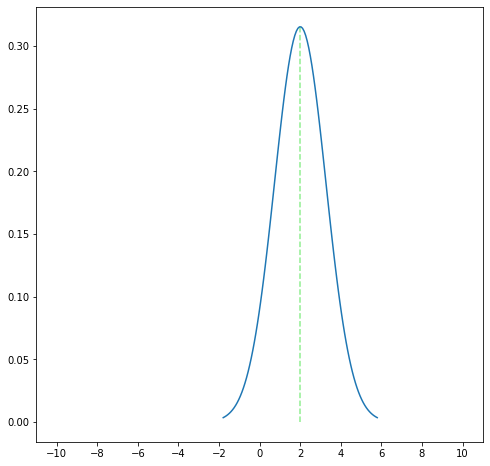

In [153]:
ax.cla()
n = 10
votes = [-1, 1, 1, -1, -1, 1,1,1,1,-1]

mu = sum(votes)
variance = mu*(1 - mu/n)
print('Variance: {:2.2f}'.format(variance))
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma))
ax.vlines(mu, color='lightgreen', linestyle='dashed', ymin=0, ymax=stats.norm.pdf(mu, mu, sigma))

ax.set_xlim(-11, 11)
ax.set_xticks(range(-10, 11, 2))


fig

One interesting remark: reframing our election this way results in a much "peakier" distribution. Reframing our election to include a larger domain has compressed our possible election outcomes significantly, resulting in a distribution with lower varance.

Now let's see how invalid votes affect this. To start, we'll augment our election with ten more ballots that have no votes: 

$$\vec{e} = [-1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].$$

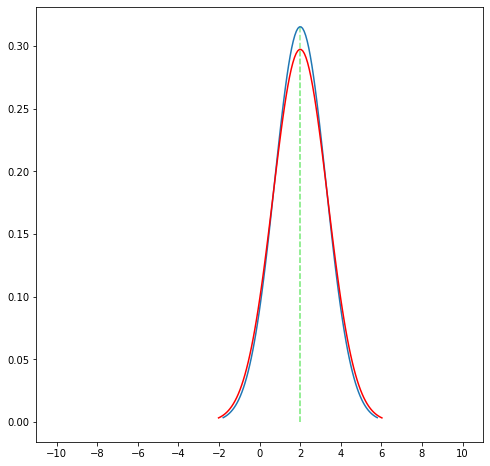

In [154]:
n = 20
votes = [-1, 1, 1, -1, -1, 1,1,1,1,-1,0,0,0,0,0,0,0,0,0,0]

margin_range = ()
mu = sum(votes)
variance = mu*(1 - mu/n)

sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), color='red')
ax.vlines(mu, color='lightgreen', linestyle='dashed', ymin=0, ymax=stats.norm.pdf(mu, mu, sigma))

ax.set_xlim(-11, 11)
ax.set_xticks(range(-10, 11, 2))


fig

Interestingly, the distribution only changed a little bit (shown in red). Let's try adding a _lot_ more invalid votes. 

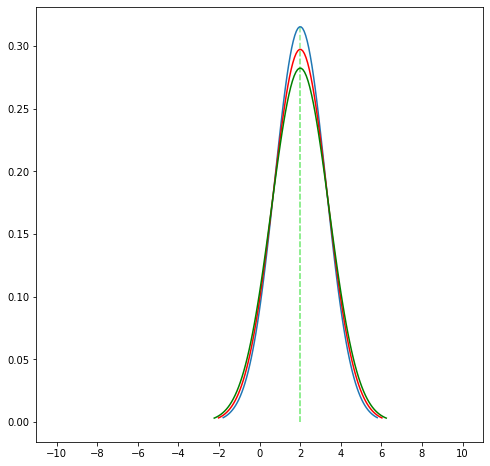

In [155]:
n = 1000
votes = [-1, 1, 1, -1, -1, 1,1,1,1,-1,0,0,0,0,0,0,0,0,0,0]

margin_range = ()
mu = sum(votes)
variance = mu*(1 - mu/n)

sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), color='green')
ax.vlines(mu, color='lightgreen', linestyle='dashed', ymin=0, ymax=stats.norm.pdf(mu, mu, sigma))

ax.set_xlim(-11, 11)
ax.set_xticks(range(-10, 11, 2))


fig

Wow, even adding 990 extra undervotes (green) doesn't flatten out our distribution that much. That's interesting: it means that invalid votes don't heavily impact the distribution of possible margins. Now we're ready to start talking about hypothesis testing. 